<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#use this website as a refenrece
#https://qiita.com/omiita/items/1735c1d048fe5f611f80
#https://www.youtube.com/watch?v=pXGBHV3y8rs&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=12

In [29]:
# the dataset,train.csv and test.csv came from https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset

In [30]:
!pip install tensorflow_text

In [31]:
pip install "tf-models-official==2.13.*"

In [32]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [33]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')

In [34]:
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]

In [35]:
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [36]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [37]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [38]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)


neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [39]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

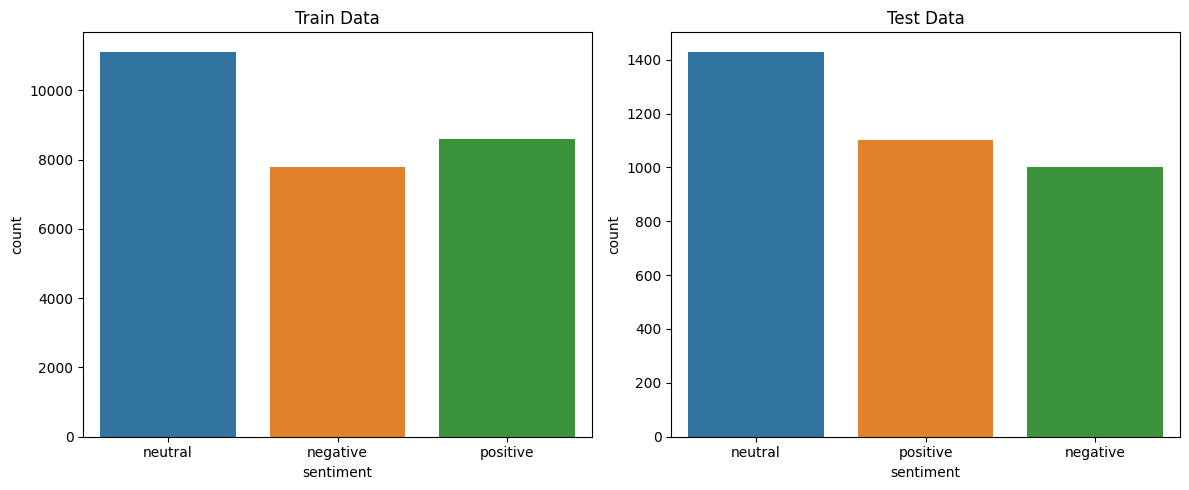

In [40]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()


## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
### neagtive → -1
### neutral → 0
### postive → 1

In [41]:
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)

In [42]:
train['label'].value_counts(normalize=True) # got same ratio before converting

 0    0.404549
 1    0.312300
-1    0.283151
Name: label, dtype: float64

In [43]:
train

,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1
...,...,...
27476,wish we could come see u on Denver husband l...,-1
27477,I`ve wondered about rake to. The client has ...,-1
27478,Yay good for both of you. Enjoy the break - y...,1
27479,But it was worth it ****.,1


In [44]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

In [45]:
y_train

0        0
1       -1
2       -1
3       -1
4       -1
        ..
27476   -1
27477   -1
27478    1
27479    1
27480    0
Name: label, Length: 27480, dtype: int64

In [46]:
y_train = pd.get_dummies(y_train, columns = ['label'])
y_test = pd.get_dummies(y_test, columns = ['label'])

In [47]:
y_test.value_counts()

-1  0  1
0   1  0    1430
    0  1    1103
1   0  0    1001
dtype: int64

## data preprocessing part


> Here, I use BERT not word2vec for fine-tuning cause BERT can cosider context.



> Whole Process of the Model


1.   text is imported in the InputLayer
2.   In the BERT layer, texts are converted into the vector so that model can retrieve it
3.  In the neural network layer, some parameter tuning is done






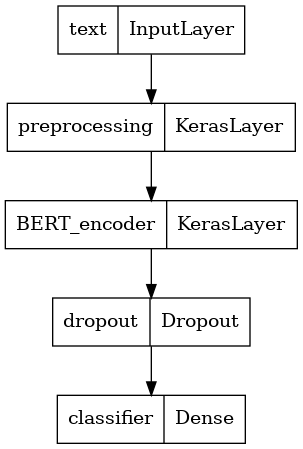



In [48]:
bert_preprocess= hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder =  hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [49]:

#binary classification ではないから注意
def build_classifier_model():
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)  #here converted into the vector

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)   #ここで3にすればcategorical?それとも1のまで数字を元にcategoricalに直す?

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  return model

In [50]:
classifier_model = build_classifier_model()

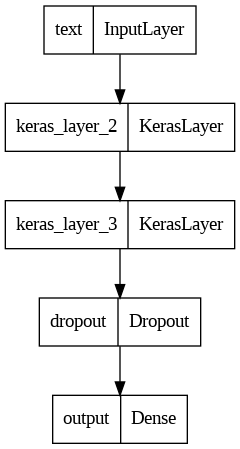

In [51]:
tf.keras.utils.plot_model(classifier_model)

In [52]:
#loss = tf.keras.losses.CategoricalCrossentropy()

# Define metrics for evaluation
#metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [53]:
#classifier_model.compile(optimizer='adam',loss=loss,metrics=metrics)

classifier_model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # 適切な損失関数を指定
              metrics=['categorical_accuracy'])  # 適切な評価メトリクスを指定


In [54]:
#history = classifier_model.fit(X_train,y_train,epochs=5)

Epoch 1/10
859/859 [==============================] - 297s 337ms/step - loss: 1.0277 - categorical_accuracy: 0.4674
Epoch 2/10
859/859 [==============================] - 289s 336ms/step - loss: 0.9519 - categorical_accuracy: 0.5342
Epoch 3/10
859/859 [==============================] - 288s 336ms/step - loss: 0.9233 - categorical_accuracy: 0.5543
Epoch 4/10
859/859 [==============================] - 288s 336ms/step - loss: 0.9085 - categorical_accuracy: 0.5679
Epoch 5/10
859/859 [==============================] - 289s 336ms/step - loss: 0.8995 - categorical_accuracy: 0.5729
Epoch 6/10
859/859 [==============================] - 290s 338ms/step - loss: 0.8997 - categorical_accuracy: 0.5748
Epoch 7/10
859/859 [==============================] - 288s 336ms/step - loss: 0.8878 - categorical_accuracy: 0.5824
Epoch 8/10
859/859 [==============================] - 291s 338ms/step - loss: 0.8887 - categorical_accuracy: 0.5817
Epoch 9/10
859/859 [==============================] - 290s 337ms/step - 

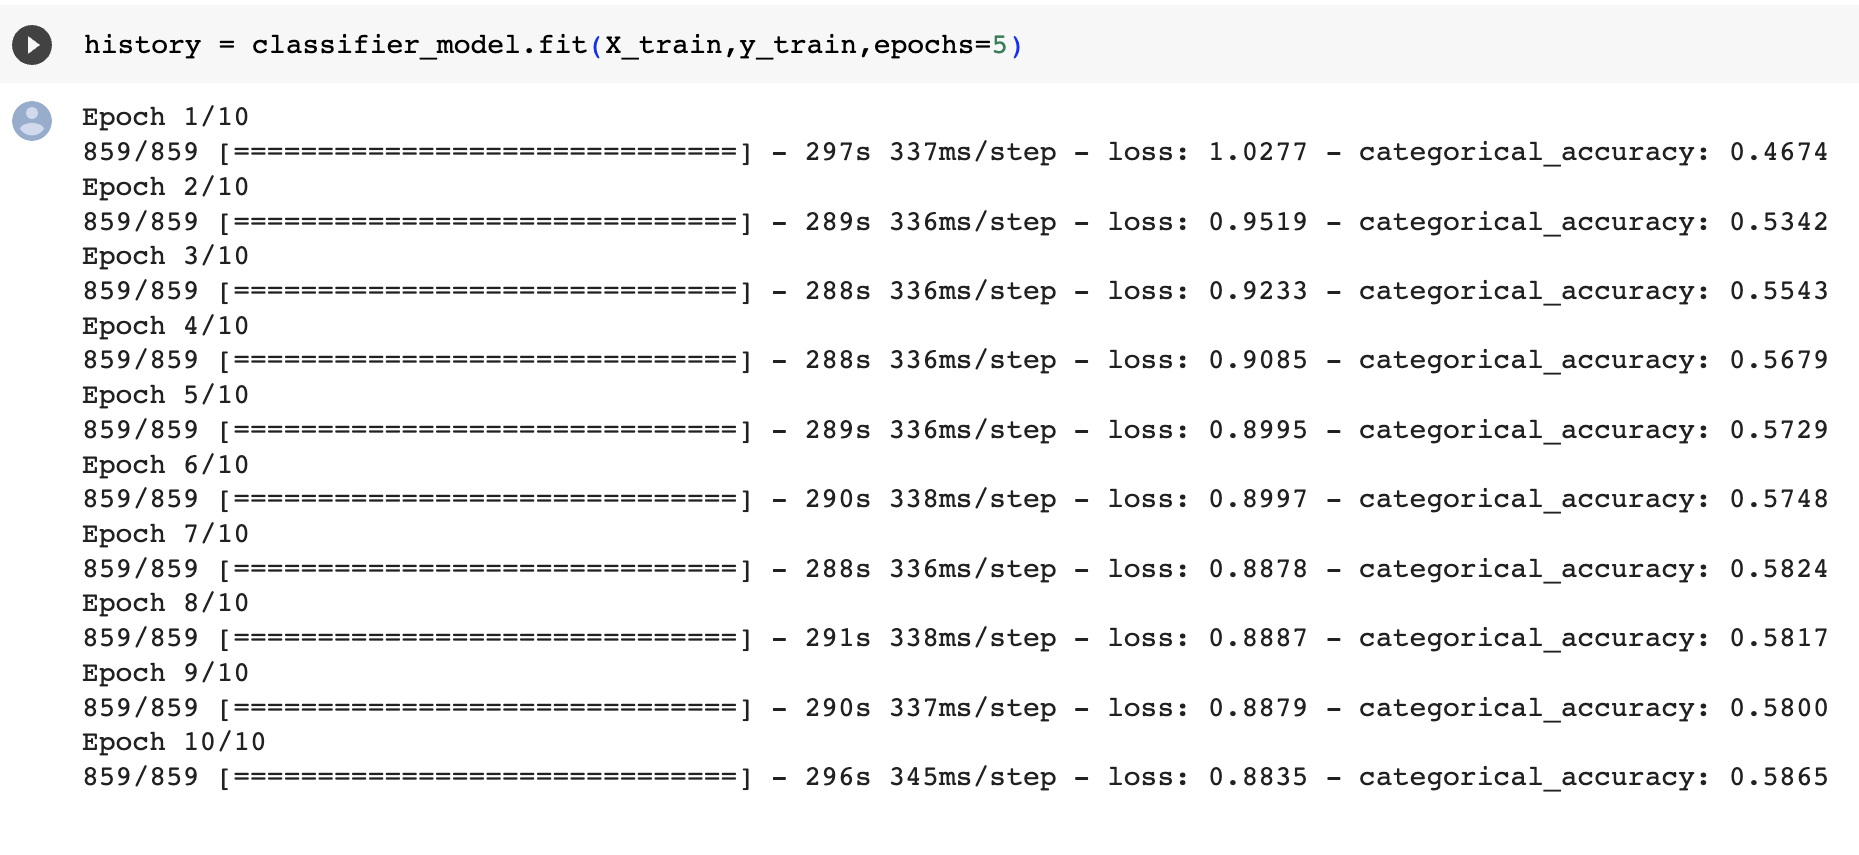with simple neural network , accuracy score was not high as expected.
the accuracy score after 10 epochs was under 60%. so i changed the plan to use hugging face.hugging face proveides the eco-system about NLP even model(torkenizer),transformer

In [55]:
#more parameter tuting section to improve accuracy